# An alternative classification model for Breast Cancer Diagnoses

**Author: Gwen Spencer**

This notebook is an addendum to my main analysis in the notebook **Data Challenge, Main Analysis.**

Though I was very satisfied with the perfromance of a simple decision tree model (particularly given that the model was highly interpretable and also used only 4 of the features - suggesting that a smaller set of features could be gathered towards future diagnoses), in this notebook I will briefly explore an alternative classification model based on **Logistic Regression**. 

Initial data processing will be very similar.

**Takeaways:**

1. By biasing my **weighting of the positive samples**, I find a Logistic Regression Model with **very high recall (mean from 10-fold crossvalidation of 0.99**) and high overall accuracy (mean from 10-fold crossvalidation of 0.96).


2. Because the features appear highly correlated, I used **iterative feature selection** to produce a sparser version of my initial Logistic Regression Model. With almost no damage to the validation metrics, I was able to **reduce the number of features in the model to 4** (rather than 8-9). The mean recall was again 0.99, with mean overall accuracy of 0.96.


3. The features remaining after feature selection for logistic regression are 'clump_thickness', 'unif_cell_size','bc', 'nn.' Three of these **match the features identified as the most important features based on their inclusion in my decision tree model**. The fact that we are observing a consistent message about which features are the most important across these two classification methods is comforting.


In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

%matplotlib inline


# 1. code number            id number
# 2. Clump Thickness               1 - 10
# 3. Uniformity of Cell Size       1 - 10
# 4. Uniformity of Cell Shape      1 - 10
# 5. Marginal Adhesion             1 - 10
# 6. Single Epithelial Cell Size   1 - 10
# 7. Bare Nuclei                   1 - 10
# 8. Bland Chromatin               1 - 10
# 9. Normal Nucleoli               1 - 10
# 10. Mitoses                       1 - 10
# 11. Class:   2 for benign, 4 for cancer


breast_cancer = pd.read_csv('breast_cancer.txt', header = None, 
names = ['code','clump_thickness', 'unif_cell_size','unif_cell_shape', 'adhesion', 'epi_cell_size','bn','bc','nn','mit','class'])

In [109]:
# Convert the existing class labels to more standard binary target labels:

natural_labels = []

for index in list(range(len(breast_cancer))):
    natural_labels.append(int((breast_cancer['class'][index]-2)/2))
    
breast_cancer['target'] = natural_labels

breast_cancer.head()

,code,clump_thickness,unif_cell_size,unif_cell_shape,adhesion,epi_cell_size,bn,bc,nn,mit,class,target
0,1000025,5,1,1,1,2,1,3,1,1,2,0
1,1002945,5,4,4,5,7,10,3,2,1,2,0
2,1015425,3,1,1,1,2,2,3,1,1,2,0
3,1016277,6,8,8,1,3,4,3,7,1,2,0
4,1017023,4,1,1,3,2,1,3,1,1,2,0


Text(0.5, 1.0, 'Correlation Between Features')

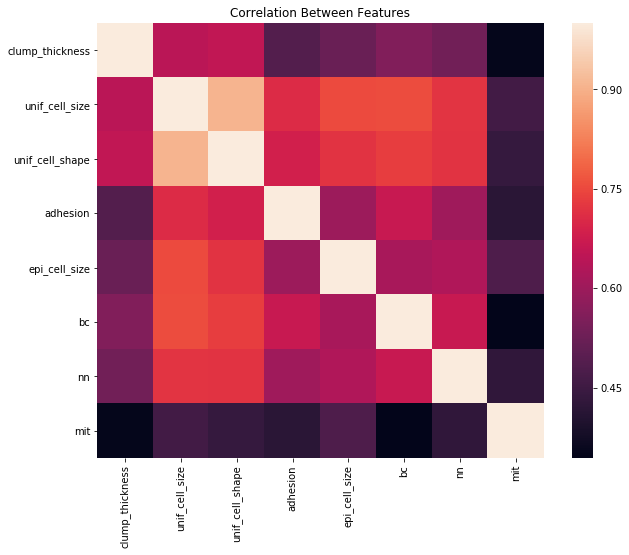

In [110]:
import seaborn as sns

features_breast_cancer = breast_cancer[['clump_thickness', 'unif_cell_size','unif_cell_shape', 'adhesion', 'epi_cell_size','bc','nn','mit']]
# Due to some missing values I've excluded one feature (bn)
# Since many other features appeared to be highly informative about the target
# in the EDA from the main analysis notebook,
# we proceed without bn for now. If our model does not perform well
# we will revisit including the bn feature, possibly imputing the missing values.


plt.rcParams["figure.figsize"] = (10,8)
corr = features_breast_cancer.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

plt.title('Correlation Between Features')

This correlation matrix shows that certain pairs of features are **very highly correlated**. Since Logistic Regression applies the logistic function to a linear combination of the features, **high correlation/colinearity of features can sometimes lead to strange behavior**.

While we plan to rely on an **L2 regularization to discourage over-fitting**, we will also **revisit the possibility of removing some features** (while retaining some other highly-correlated feature) after observing our initial model fit.

In [111]:
breast_cancer = breast_cancer[['clump_thickness', 'unif_cell_size','unif_cell_shape', 'adhesion', 'epi_cell_size','bc','nn','mit','target']]

In [112]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

X = breast_cancer[['clump_thickness', 'unif_cell_size','unif_cell_shape', 'adhesion', 'epi_cell_size','bc','nn','mit']]
Y = breast_cancer['target']


# Since we want to prioritize high recall, let's heavily weight the target (label of 1):
bias_for_recall ={0:1, 1:6}
clf = LogisticRegression(penalty='l2',class_weight=bias_for_recall,solver='liblinear', max_iter=100)

# Note: If we use 'balanced' weights 
# (which simulate balancing the class-label frequency) 
# or, even more-so, if we weight each original sample equally,
# Recall is quite a bit lower than with the bias we define above:

#clf = LogisticRegression(class_weight='balanced',solver='liblinear', max_iter=100)
#clf = LogisticRegression(solver='liblinear', max_iter=100)

In [113]:
scores = cross_val_score(clf, X, Y, cv=10,scoring ='accuracy')
#print(scores)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("   ")

scores = cross_val_score(clf, X, Y, cv=10,scoring ='precision')
#print(scores)

print("Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("   ")

scores = cross_val_score(clf, X, Y, cv=10,scoring ='recall')
#print(scores)

print("Recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.96 (+/- 0.06)
   
Precision: 0.92 (+/- 0.12)
   
Recall: 0.99 (+/- 0.04)


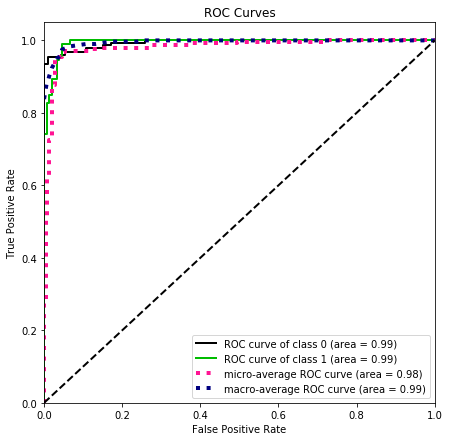

The coefficients in the fitted model were:


array([[ 0.47002061,  0.25490718,  0.45525548,  0.305341  ,  0.09137494,
         0.31901892,  0.16445205, -0.1254997 ]])

In [114]:
#ROC Curve for a single train/test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.35)

clf = clf.fit(X_train, y_train)

predicted_probas = clf.predict_proba(X_test)

plt.rcParams["figure.figsize"] = (7, 7)
import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_roc(y_test, predicted_probas)
plt.show()


print('The coefficients in the fitted model were:')
clf.coef_

A simple Logistic Regression Model performs very well for our prediction task. The 10-fold cross-validation  results above suggest that the behavior in the ROC curve shown for a particular train/test split is quite typical: this model can acheive **almost perfect recall with a false positive rate of less than 10%**. Since the follow-up of a positive test result is usually a second round of screening, and the possibility of recovering from cancer is much greater if the condition is detected as early as possible, this balance (which almost never misses a true cancer) seems highly promising.

While we obsevre that the performance metrics for Logistic Regression (particularly recall) are very competitive with those we observed for the decision-tree model, this model is currently putting rather **substantial amounts of weight on many features** including a negative coefficient on one feature that may be hard to interpret/be compensating for a high positive coefficient of a different highly-correlated feature. Our correlation matrix suggested that many pairs of features were highly correlated, so we might suspect that the model could be simplified by **concentrating weight on a smaller number of features**.

To obtain a sparser (and thus more interpetable) model, we'll perform some **feature selection**. In particular, we will test if removing certain features causes a substantial decrease in our cross-validation metrics. If such a removal **doesn't damage the metrics too much**, we woud favor the sparser model.

## Feature Selection: Iterative Feature Removal

Setting a goal of 0.98 for recall and 0.95 for overall accuracy, we use 10-fold-cross-validation to estimate the impact on predictive performance as we remove one feature at a time. We will repeat this procedure iteratively as long as performance metrics continue to be strong.



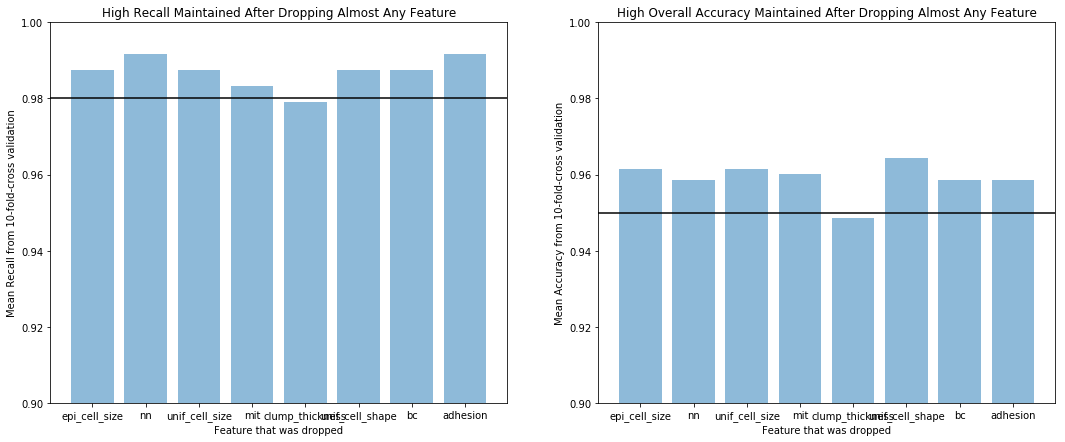

In [115]:
# Consider dropping each feature separately
# After dropping exactly one feature, 
# which combination of remaining features 
# gives the best performance?


full_feature_set ={'clump_thickness', 'unif_cell_size','unif_cell_shape', 'adhesion', 'epi_cell_size','bc','nn','mit'}

feature_that_was_dropped = []
resulting_recall = []
resulting_accuracy = []

for dropped_feature in full_feature_set:
    feature_that_was_dropped.append(dropped_feature)
    
    X = breast_cancer[['clump_thickness', 'unif_cell_size','unif_cell_shape', 'adhesion', 'epi_cell_size','bc','nn','mit']]
    X = X.drop(columns = dropped_feature)
    Y = breast_cancer['target']
    
    acc_scores = cross_val_score(clf, X, Y, cv=10,scoring ='accuracy')
    resulting_accuracy.append(acc_scores.mean())
    
    recall_scores = cross_val_score(clf, X, Y, cv=10,scoring ='recall')
    resulting_recall.append(recall_scores.mean())
    
    
plt.rcParams["figure.figsize"] = (18,7)
plt.subplot(121)
plt.bar(feature_that_was_dropped, resulting_recall, align='center', alpha=0.5) 
plt.title('High Recall Maintained After Dropping Almost Any Feature')
plt.ylabel('Mean Recall from 10-fold-cross validation')
plt.xlabel('Feature that was dropped')
plt.ylim(0.9,1.0)
plt.axhline(y = 0.98,color ='black')


plt.subplot(122)
plt.bar(feature_that_was_dropped, resulting_accuracy, align='center', alpha=0.5) 
plt.title('High Overall Accuracy Maintained After Dropping Almost Any Feature')
plt.ylabel('Mean Accuracy from 10-fold-cross validation')
plt.xlabel('Feature that was dropped')
plt.ylim(0.9,1.0)
plt.axhline(y = 0.95,color ='black')
    

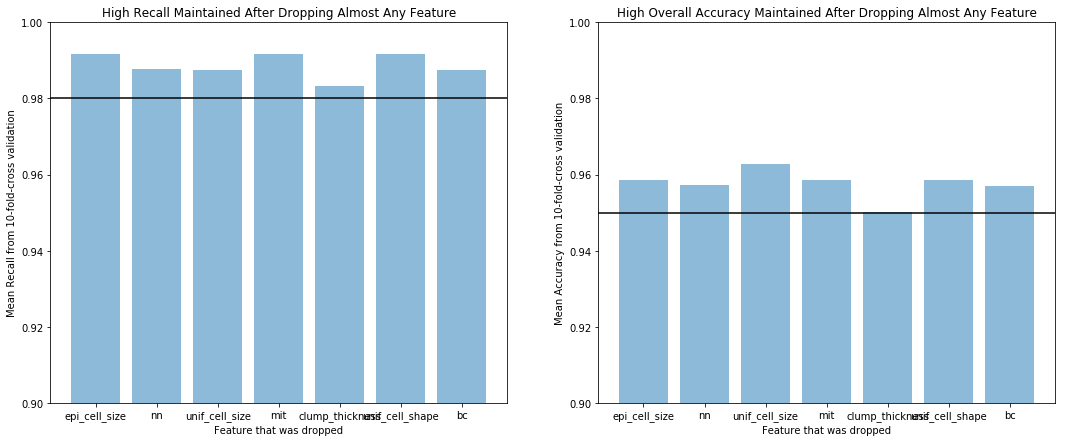

In [116]:
# Since high recall is our top goal, let's DROP ADHESION and proceed in the same way:

# Consider dropping each feature separately
# After dropping exactly one feature, 
# which combination of remaining features 
# gives the best performance?

# Adhesion removed:
full_feature_set ={'clump_thickness', 'unif_cell_size','unif_cell_shape', 'epi_cell_size','bc','nn','mit'}

feature_that_was_dropped = []
resulting_recall = []
resulting_accuracy = []

for dropped_feature in full_feature_set:
    feature_that_was_dropped.append(dropped_feature)
    
    # Adhesion removed:
    X = breast_cancer[['clump_thickness', 'unif_cell_size','unif_cell_shape', 'epi_cell_size','bc','nn','mit']]
    X = X.drop(columns = dropped_feature)
    Y = breast_cancer['target']
    
    acc_scores = cross_val_score(clf, X, Y, cv=10,scoring ='accuracy')
    resulting_accuracy.append(acc_scores.mean())
    
    recall_scores = cross_val_score(clf, X, Y, cv=10,scoring ='recall')
    resulting_recall.append(recall_scores.mean())
    
    
plt.rcParams["figure.figsize"] = (18,7)
plt.subplot(121)
plt.bar(feature_that_was_dropped, resulting_recall, align='center', alpha=0.5) 
plt.title('High Recall Maintained After Dropping Almost Any Feature')
plt.ylabel('Mean Recall from 10-fold-cross validation')
plt.xlabel('Feature that was dropped')
plt.ylim(0.9,1.0)
plt.axhline(y = 0.98,color ='black')


plt.subplot(122)
plt.bar(feature_that_was_dropped, resulting_accuracy, align='center', alpha=0.5) 
plt.title('High Overall Accuracy Maintained After Dropping Almost Any Feature')
plt.ylabel('Mean Accuracy from 10-fold-cross validation')
plt.xlabel('Feature that was dropped')
plt.ylim(0.9,1.0)
plt.axhline(y = 0.95,color ='black')
    

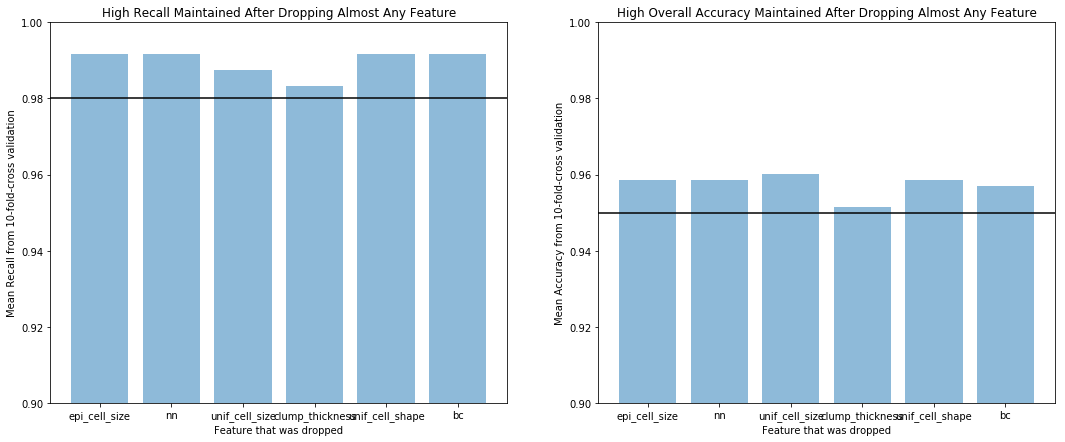

In [117]:
# Since high recall is our top goal, let's DROP MIT and proceed in the same way:

# Consider dropping each feature separately
# After dropping exactly one feature, 
# which combination of remaining features 
# gives the best performance?

#MIT removed:
full_feature_set ={'clump_thickness', 'unif_cell_size','unif_cell_shape', 'epi_cell_size','bc','nn'}

feature_that_was_dropped = []
resulting_recall = []
resulting_accuracy = []

for dropped_feature in full_feature_set:
    feature_that_was_dropped.append(dropped_feature)
    
    #MIT removed:
    X = breast_cancer[['clump_thickness', 'unif_cell_size','unif_cell_shape', 'epi_cell_size','bc','nn']]
    X = X.drop(columns = dropped_feature)
    Y = breast_cancer['target']
    
    acc_scores = cross_val_score(clf, X, Y, cv=10,scoring ='accuracy')
    resulting_accuracy.append(acc_scores.mean())
    
    recall_scores = cross_val_score(clf, X, Y, cv=10,scoring ='recall')
    resulting_recall.append(recall_scores.mean())
    
    
plt.rcParams["figure.figsize"] = (18,7)
plt.subplot(121)
plt.bar(feature_that_was_dropped, resulting_recall, align='center', alpha=0.5) 
plt.title('High Recall Maintained After Dropping Almost Any Feature')
plt.ylabel('Mean Recall from 10-fold-cross validation')
plt.xlabel('Feature that was dropped')
plt.ylim(0.9,1.0)
plt.axhline(y = 0.98,color ='black')


plt.subplot(122)
plt.bar(feature_that_was_dropped, resulting_accuracy, align='center', alpha=0.5) 
plt.title('High Overall Accuracy Maintained After Dropping Almost Any Feature')
plt.ylabel('Mean Accuracy from 10-fold-cross validation')
plt.xlabel('Feature that was dropped')
plt.ylim(0.9,1.0)
plt.axhline(y = 0.95,color ='black')
    

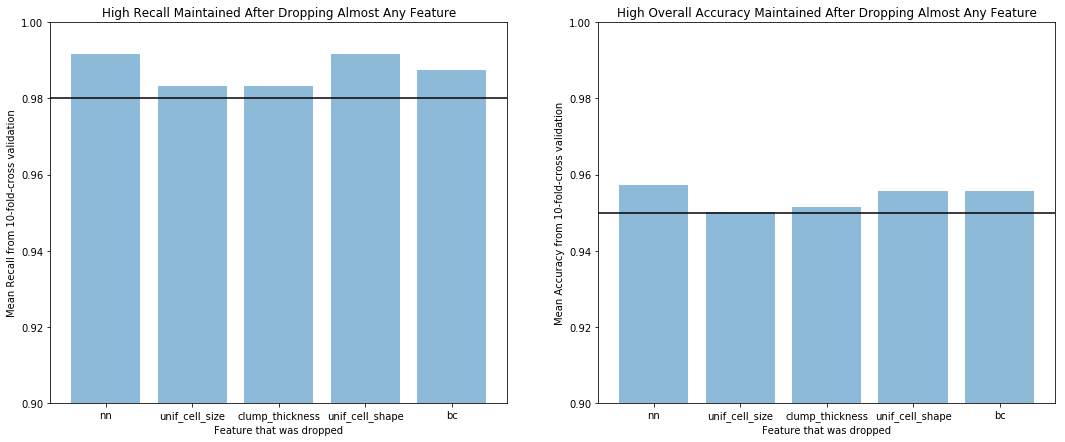

In [118]:
# Since high recall is our top goal, let's DROP epi_cell_size and proceed in the same way:

# Consider dropping each feature separately
# After dropping exactly one feature, 
# which combination of remaining features 
# gives the best performance?

#epi_cell_size removed:
full_feature_set ={'clump_thickness', 'unif_cell_size','unif_cell_shape','bc','nn'}

feature_that_was_dropped = []
resulting_recall = []
resulting_accuracy = []

for dropped_feature in full_feature_set:
    feature_that_was_dropped.append(dropped_feature)
    
    #epi_cell_size removed:
    X = breast_cancer[['clump_thickness', 'unif_cell_size','unif_cell_shape','bc','nn']]
    X = X.drop(columns = dropped_feature)
    Y = breast_cancer['target']
    
    acc_scores = cross_val_score(clf, X, Y, cv=10,scoring ='accuracy')
    resulting_accuracy.append(acc_scores.mean())
    
    recall_scores = cross_val_score(clf, X, Y, cv=10,scoring ='recall')
    resulting_recall.append(recall_scores.mean())
    
    
plt.rcParams["figure.figsize"] = (18,7)
plt.subplot(121)
plt.bar(feature_that_was_dropped, resulting_recall, align='center', alpha=0.5) 
plt.title('High Recall Maintained After Dropping Almost Any Feature')
plt.ylabel('Mean Recall from 10-fold-cross validation')
plt.xlabel('Feature that was dropped')
plt.ylim(0.9,1.0)
plt.axhline(y = 0.98,color ='black')


plt.subplot(122)
plt.bar(feature_that_was_dropped, resulting_accuracy, align='center', alpha=0.5) 
plt.title('High Overall Accuracy Maintained After Dropping Almost Any Feature')
plt.ylabel('Mean Accuracy from 10-fold-cross validation')
plt.xlabel('Feature that was dropped')
plt.ylim(0.9,1.0)
plt.axhline(y = 0.95,color ='black')
    

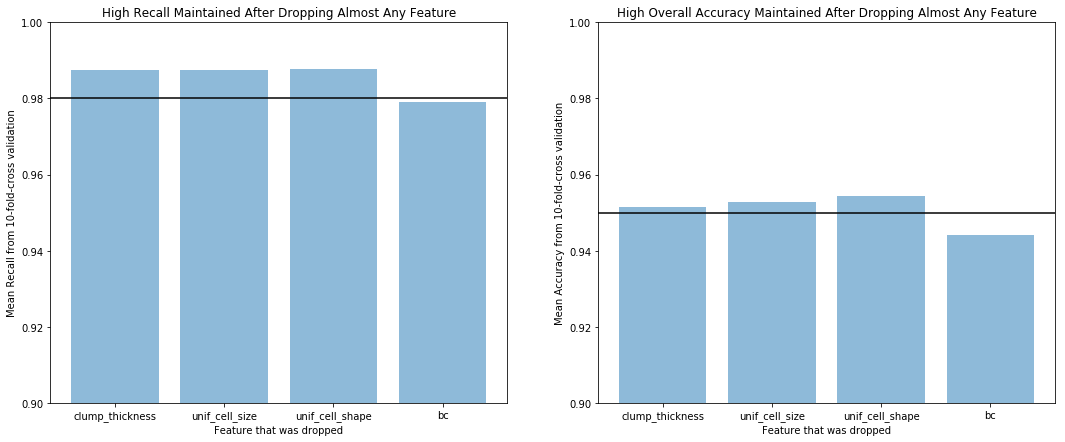

In [119]:
# Since high recall is our top goal, let's nn and proceed in the same way:

# Consider dropping each feature separately
# After dropping exactly one feature, 
# which combination of remaining features 
# gives the best performance?

#nn removed:
full_feature_set ={'clump_thickness', 'unif_cell_size','unif_cell_shape','bc'}

feature_that_was_dropped = []
resulting_recall = []
resulting_accuracy = []

for dropped_feature in full_feature_set:
    feature_that_was_dropped.append(dropped_feature)
    
    #nn removed:
    X = breast_cancer[['clump_thickness', 'unif_cell_size','unif_cell_shape','bc']]
    X = X.drop(columns = dropped_feature)
    Y = breast_cancer['target']
    
    acc_scores = cross_val_score(clf, X, Y, cv=10,scoring ='accuracy')
    resulting_accuracy.append(acc_scores.mean())
    
    recall_scores = cross_val_score(clf, X, Y, cv=10,scoring ='recall')
    resulting_recall.append(recall_scores.mean())
    
    
plt.rcParams["figure.figsize"] = (18,7)
plt.subplot(121)
plt.bar(feature_that_was_dropped, resulting_recall, align='center', alpha=0.5) 
plt.title('High Recall Maintained After Dropping Almost Any Feature')
plt.ylabel('Mean Recall from 10-fold-cross validation')
plt.xlabel('Feature that was dropped')
plt.ylim(0.9,1.0)
plt.axhline(y = 0.98,color ='black')


plt.subplot(122)
plt.bar(feature_that_was_dropped, resulting_accuracy, align='center', alpha=0.5) 
plt.title('High Overall Accuracy Maintained After Dropping Almost Any Feature')
plt.ylabel('Mean Accuracy from 10-fold-cross validation')
plt.xlabel('Feature that was dropped')
plt.ylim(0.9,1.0)
plt.axhline(y = 0.95,color ='black')
    

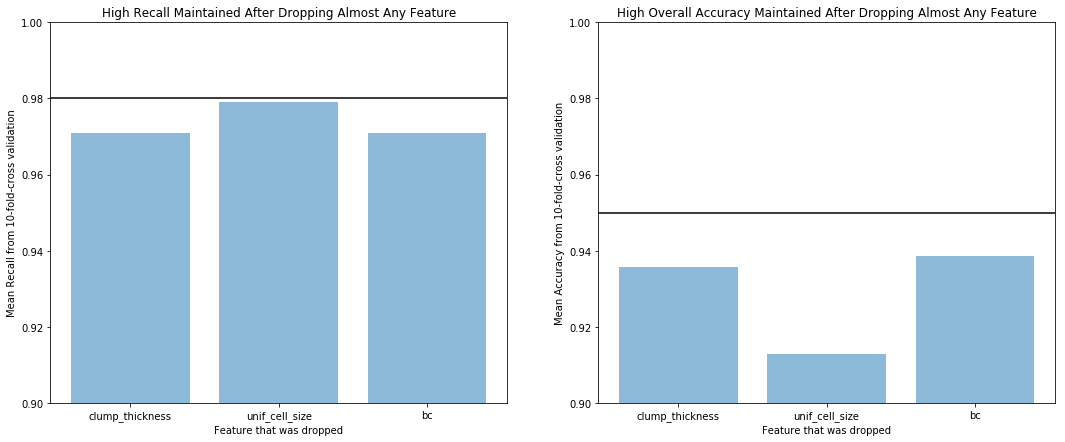

In [123]:
# Since high recall is our top goal, let's drop unif_cell_shape and proceed in the same way:

# Consider dropping each feature separately
# After dropping exactly one feature, 
# which combination of remaining features 
# gives the best performance?

#unif_cell_shape removed:
full_feature_set ={'clump_thickness', 'unif_cell_size','bc'}

feature_that_was_dropped = []
resulting_recall = []
resulting_accuracy = []

for dropped_feature in full_feature_set:
    feature_that_was_dropped.append(dropped_feature)
    
    #unif_cell_shape removed:
    X = breast_cancer[['clump_thickness', 'unif_cell_size','bc']]
    X = X.drop(columns = dropped_feature)
    Y = breast_cancer['target']
    
    acc_scores = cross_val_score(clf, X, Y, cv=10,scoring ='accuracy')
    resulting_accuracy.append(acc_scores.mean())
    
    recall_scores = cross_val_score(clf, X, Y, cv=10,scoring ='recall')
    resulting_recall.append(recall_scores.mean())
    
    
plt.rcParams["figure.figsize"] = (18,7)
plt.subplot(121)
plt.bar(feature_that_was_dropped, resulting_recall, align='center', alpha=0.5) 
plt.title('High Recall Maintained After Dropping Almost Any Feature')
plt.ylabel('Mean Recall from 10-fold-cross validation')
plt.xlabel('Feature that was dropped')
plt.ylim(0.9,1.0)
plt.axhline(y = 0.98,color ='black')


plt.subplot(122)
plt.bar(feature_that_was_dropped, resulting_accuracy, align='center', alpha=0.5) 
plt.title('High Overall Accuracy Maintained After Dropping Almost Any Feature')
plt.ylabel('Mean Accuracy from 10-fold-cross validation')
plt.xlabel('Feature that was dropped')
plt.ylim(0.9,1.0)
plt.axhline(y = 0.95,color ='black')
    

At this point, **dropping any more features causes a drop below our pre-specified goals for mean recall and accuracy**. Let's check the performance of the current model. 

Since we've been ignoring the confidence interval associated with our cross-validation (and guiding our iterative feature selection based only on the means of recall and accuracy), we may reconsider our last feature removal (or two!) after viewing these results.  

Accuracy: 0.95 (+/- 0.08)
   
Precision: 0.90 (+/- 0.16)
   
Recall: 0.99 (+/- 0.04)


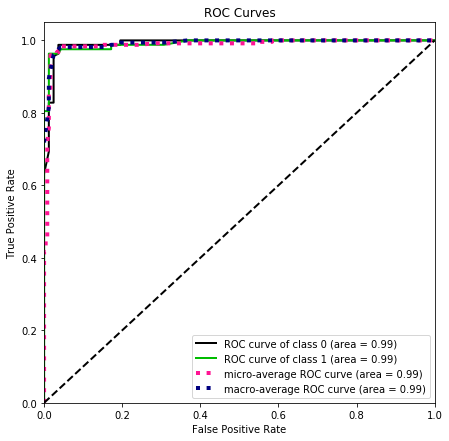

The coefficients in the fitted model were:


array([[0.5289122 , 0.89451539, 0.63238112]])

In [128]:
X = breast_cancer[['clump_thickness', 'unif_cell_size','bc']]
Y = breast_cancer['target']


# Since we want to prioritize high recall, let's heavily weight the target (label of 1):
bias_for_recall ={0:1, 1:6}
clf = LogisticRegression(penalty='l2',class_weight=bias_for_recall,solver='liblinear', max_iter=100)

scores = cross_val_score(clf, X, Y, cv=10,scoring ='accuracy')
#print(scores)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("   ")

scores = cross_val_score(clf, X, Y, cv=10,scoring ='precision')
#print(scores)

print("Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("   ")

scores = cross_val_score(clf, X, Y, cv=10,scoring ='recall')
#print(scores)

print("Recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#ROC Curve for a single train/test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.35)

clf = clf.fit(X_train, y_train)

predicted_probas = clf.predict_proba(X_test)

plt.rcParams["figure.figsize"] = (7, 7)
import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_roc(y_test, predicted_probas)
plt.show()


print('The coefficients in the fitted model were:')
clf.coef_

The confidence intervals for the 3-feature model stretch 
a bit lower than we are comfortable with for overall accuracy 
(because of low and widely-variable precision)
We will **add back nn** to try to tighten this up a bit.

Accuracy: 0.96 (+/- 0.06)
   
Precision: 0.90 (+/- 0.14)
   
Recall: 0.99 (+/- 0.03)


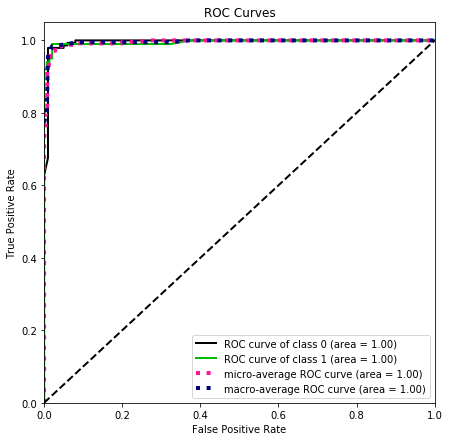

The coefficients in the fitted model were:


array([[0.43954743, 0.75980778, 0.51000207, 0.2456462 ]])

In [133]:
# The confidence intervals for the 3-feature model stretch 
# a bit lower than we are comfortable with for overall accuracy 
# (because of lower and widely variable precision)
# We will add back nn to try to tighten this up a bit.

X = breast_cancer[['clump_thickness', 'unif_cell_size','bc', 'nn']]
Y = breast_cancer['target']


# Since we want to prioritize high recall, let's heavily weight the target (label of 1):
bias_for_recall ={0:1, 1:6}
clf = LogisticRegression(penalty='l2',class_weight=bias_for_recall,solver='liblinear', max_iter=100)

scores = cross_val_score(clf, X, Y, cv=10,scoring ='accuracy')
#print(scores)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("   ")

scores = cross_val_score(clf, X, Y, cv=10,scoring ='precision')
#print(scores)

print("Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("   ")

scores = cross_val_score(clf, X, Y, cv=10,scoring ='recall')
#print(scores)

print("Recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#ROC Curve for a single train/test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.35)

clf = clf.fit(X_train, y_train)

predicted_probas = clf.predict_proba(X_test)

plt.rcParams["figure.figsize"] = (7, 7)
import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_roc(y_test, predicted_probas)
plt.show()


print('The coefficients in the fitted model were:')
clf.coef_

Adding 'nn' back gives **confidence intervals for orverall accuracy that don't go below 90%**. Since this still **reduces the number of features from 8 to 4**, we consider this a **successful feature selection** outcome. 

Our validation measures (particularly for recall) are competitive with the full 8-parameter Logistic Regression model, but our model is now relatively more interpretable and intuitive for medical professionals. For example, the model coefficients are all positive, and, in terms of interpretability, all coefficents are close to multiples of 0.25. 

This allows qualitative statements like, *"A single increase of 1 for Uniform Cell Size increases the prediction of cancer roughly the same amount as two simultaneous increases of 1 in Bland Chromatin and Normal Nucleoli."*

